## Principal Compontent Analysis: feats & rxn_solUD
Some considerations or assumptions:
-   Correlation between features
-   Std is requerid OK 
-   Outliers?
-   No missing values. OK

In [698]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = [10, 10]

In [2]:
%cd ..

/home/belu/VS Workplace/2021-re-pendleton-perovskite


In [699]:
import src.data.notebook_utils as utils
results = '/notebook/results/correlation/'
df = utils.read_data()
binary_output = df['_out_crystalscore']
columns_by_type = utils.get_columns(df.columns)
used_data = utils.get_used_columns(df.columns)


In [700]:
for key, cols in columns_by_type.items():
    print('#Cols for type {}: {}'.format(key, len(cols)))

#Cols for type _rxn_: 9
#Cols for type _feat_: 67
#Cols for type solUD: 8
#Cols for type chem: 36


In [701]:
def apply_pca(df, cols, n_components):
    scaler = StandardScaler()
    std_df =pd.DataFrame(scaler.fit_transform(df[cols]), columns=cols)
    pca_number = min(len(cols), n_components)
    pca_columns = ['PCA_'+ str(n) for n in range(1,pca_number+1)]
    pca = PCA(n_components=pca_number, svd_solver = 'auto')
    principal_components=pca.fit_transform(std_df)
    pca_df = pd.DataFrame(data = principal_components, columns = pca_columns)
    return pca, pca_df

In [702]:
def plot_scree_pca(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of components')
    plt.ylabel('cumulative explained variance');


#### Visualization with Plotly

Para datos simétricas, cols y filas

In [703]:
import plotly.express as px
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)

def plot_heap_map(data, cols, rows, title):
    fig = px.imshow(data,
                labels=dict(x="", y="Componente", color=""),
                x=cols,
                y=rows,
                color_continuous_scale=px.colors.sequential.Blackbody             

               )
    fig.update_coloraxes(colorbar={
        'x':1.01,
        'y' : 0,
        'lenmode': "pixels",
        'len':220,
        'nticks':15

    })

    fig.update_layout(yaxis={
                        'showticklabels': True,
                         'tickmode':'linear',
                        })
    fig.update_layout(xaxis={ 
                        'showticklabels': True, 
                        'tickmode':'linear',
                        })
                                                
    fig.update_layout({'width':800, 'height':400,
                        'showlegend':False, 'hovermode': 'closest',
                        })
    fig.show()

Para datos asimétricos, solo en eje x

In [710]:
import plotly.figure_factory as ff
import scipy.cluster.hierarchy as sch
import plotly.graph_objects as go

#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html dendogramMethod

def plot_heap_map_with_dendogram(data, cols, rows, title, dendogramMethod='weighted'):
    data_array = data
    labels = cols
    colorScale = 'default'

    # Add upper dendogram
    fig = ff.create_dendrogram(data.transpose(), orientation='bottom', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, optimal_ordering=True), labels=labels)
    for i in range(len(fig['data'])):
        fig['data'][i]['yaxis'] = 'y2'

    # Create Side Dendrogram to aux calculation in heatmap
    #dendro_side = ff.create_dendrogram(data_array, orientation='right', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, metric=distanceMethod,  optimal_ordering=True) )
    dendro_side = ff.create_dendrogram(data.transpose(), orientation='right', linkagefun=lambda x: sch.linkage(x, method=dendogramMethod, optimal_ordering=True) )

    for i in range(len(dendro_side['data'])):
        dendro_side['data'][i]['xaxis'] = 'x2'
   
    # Delete side dendograms
    # for data in dendro_side['data']:
     #   fig.add_trace(data)
    
    # Create and add heatmap
    dendro_leaves = dendro_side['layout']['yaxis']['ticktext']
    dendro_leaves = list(map(int, dendro_leaves))
    heat_data = data_array
    heat_data = heat_data[:,dendro_leaves]
    heatmap = go.Heatmap(
        z = heat_data,
        colorbar = {'len':0.8, 'nticks':15, 'title':'loadings'},
        colorscale='Blackbody',
    )
    heatmap['y'] = [n for n in range(8)] 
    heatmap['x'] = fig['layout']['xaxis']['tickvals']
   
    fig.add_trace(heatmap)

    fig.update_layout({'width':1200, 'height':800,
                        'showlegend':False,
                        'boxmode': 'group',
                        })

        # Edit xaxis
    fig.update_layout(xaxis={'domain': [1, 1],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'ticks':""})
    # Edit xaxis2
    fig.update_layout(xaxis2={'domain': [1, .8],
                                    'mirror': False,
                                    'showgrid': False,
                                    'showline': False,
                                    'zeroline': False,
                                    'showticklabels': False,
                                    'ticks':""})

    # Edit yaxis
      # Edit yaxis
    fig.update_layout(yaxis={'domain': [0.1, 0.8],
                                'mirror': False,
                                'showgrid': False,
                                'showline': False,
                                'zeroline': False,
                                'showticklabels': True,
                                'tickmode':'array',
                                'ticks': "",
                                'title': 'Componente PCA'
                        })
    # Edit yaxis2
    fig.update_layout(yaxis2={'domain':[0.8, 1],
                            'mirror': False,
                            'showgrid': False,
                            'showline': False,
                            'zeroline': False,
                            'showticklabels': False,
                            'ticks':""})

    fig.update_layout(title={
                    'text': title,
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})

    fig['layout']['yaxis']['ticktext'] = ['PCA '+str(n) for n in range(1,9)] 
    fig['layout']['yaxis']['tickvals'] = [n for n in range(0,8)] 


    fig.show()

### Propiedades físico-químicas

In [711]:
df_feat = df[columns_by_type['_feat_']]

In [712]:
df_feat_noctes = df_feat.loc[:, (df_feat != df_feat.iloc[0]).any()] 
df_feat_cols = df_feat_noctes.columns
pca_ft_nocte, transformed_data = apply_pca(df, df_feat_cols, 20)

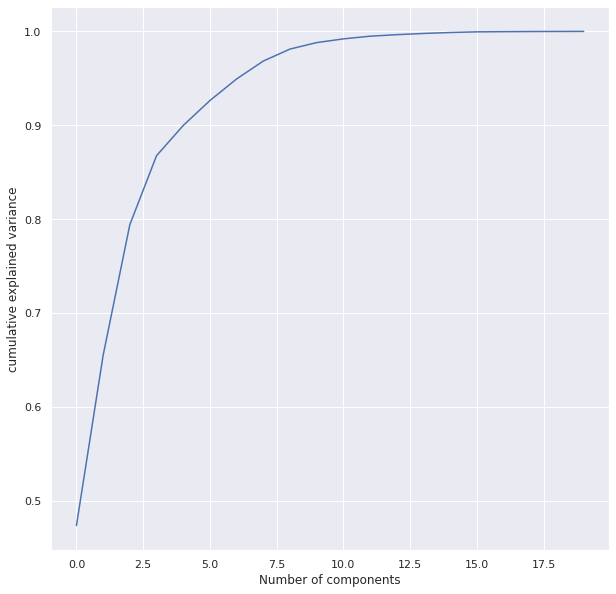

In [713]:
plot_scree_pca(pca_ft_nocte)

Drop all constants columns does not affect pca results

In [714]:
pca_ft_nocte.components_[12:,:].shape

(8, 59)

In [715]:
rows = [ "PCA"+str(x) for x in range(1,9)]
plot_heap_map_with_dendogram(pca_ft_nocte.components_[12:,:], df_feat_cols, rows, 'Propiedades físico-químicas')

In [716]:
#rows = [ "PCA"+str(x) for x in range(1,9)]
#plot_heap_map(pca_ft_nocte.components_[12:,:], df_feat_cols, rows, '')

In [717]:
def sns_clustermap(data, df_feat_cols, rows):
    cluster_data = pd.DataFrame(data, columns=df_feat_cols, index=rows)
    g = sns.clustermap(cluster_data, xticklabels=True, yticklabels=True, figsize=(15, 13), cmap='Blues')

In [718]:
#sns_clustermap(pca_ft_nocte.components_[12:,:], df_feat_cols, rows)

#### Primeras dos/tres componentes para solo propiedades FQ



In [719]:
df["_out_crystalscore"] = df["_out_crystalscore"].astype(str)

In [720]:
df['_out_crystalscore'].value_counts()

1.0    3055
4.0    1250
2.0    1212
3.0     675
0.0      49
Name: _out_crystalscore, dtype: int64

In [721]:
components = 2
pca_two_c, transformed_data = apply_pca(df, list(columns_by_type['_feat_']), components)

In [722]:
len(transformed_data)

6241

In [723]:
transformed_data

,PCA_1,PCA_2
0,6.531762,0.516638
1,6.531762,0.516638
2,6.531762,0.516638
3,6.531762,0.516638
4,6.531762,0.516638
...,...,...
6236,9.411379,4.051364
6237,9.411379,4.051364
6238,9.411379,4.051364
6239,9.411379,4.051364


Many samples are transformed to the same rows

In [724]:
len(transformed_data.groupby(['PCA_1', 'PCA_2']).size().reset_index(name='Count'))

33

if tipo de cristal == 4 cristaliza else no cristaliza

In [729]:
loadings = pca_two_c.components_.T * np.sqrt(pca_two_c.explained_variance_)

fig = px.scatter(transformed_data, x='PCA_1', y='PCA_2', color=df['_out_crystalscore'], width=800, height=600)
fig.update_layout(
    legend=dict(
        title="Tipo de cristal",
    )
)
fig.update_layout(title={
                    'text': 'Propiedades FQ',
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show()

In [730]:
pca_number=3
pca_two_c, transformed_data = apply_pca(df, list(columns_by_type['_feat_']), pca_number)
print(len(transformed_data.groupby(['PCA_1', 'PCA_2', 'PCA_3']).size().reset_index(name='Count')))
loadings = pca_two_c.components_.T * np.sqrt(pca_two_c.explained_variance_)
fig = px.scatter_3d(transformed_data, x='PCA_1', y='PCA_2', z = 'PCA_3', color=df['_out_crystalscore'], width=700, height=600)
fig.update_layout(
    legend=dict(
        title="Tipo de cristal",
    )
)
fig.update_layout(title={
                    'text': 'Propiedades FQ',
                    'y':0.9,
                    'x':0.5,
                    'xanchor': 'center',
                    'yanchor': 'top'})
fig.show()


35


In [60]:
np.savetxt("heapmap_data.csv", pca_ft_nocte.components_[:8,], delimiter=",")

In [14]:
'''plt.figure(figsize=(30,15))
#ordenar por aporte de componente
# transponer 
ax = sns.heatmap(pca_ft_nocte.components_[:8,],
                 cmap='YlGnBu',
                 yticklabels=,
                 xticklabels=df_feat_cols, cbar=True, square=True, cbar_kws={"shrink": .2})'''

'plt.figure(figsize=(30,15))\n#ordenar por aporte de componente\n# transponer \nax = sns.heatmap(pca_ft_nocte.components_[:8,],\n                 cmap=\'YlGnBu\',\n                 yticklabels=,\n                 xticklabels=df_feat_cols, cbar=True, square=True, cbar_kws={"shrink": .2})'

### propiedades físico-químicas + condiciones de reacción

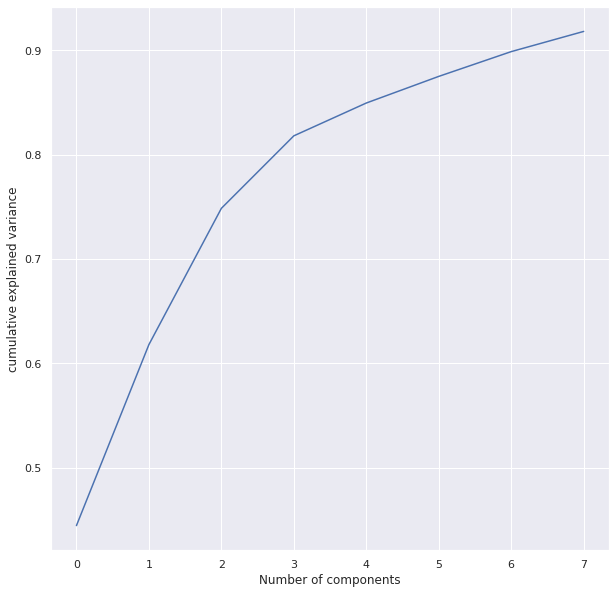

In [738]:
feat_solUD = list(columns_by_type['_feat_']) + list(columns_by_type['solUD'])
df_fq_rxn = df[feat_solUD]
pca, pca_df = apply_pca(df, feat_solUD, 8)
plot_scree_pca(pca)

In [739]:
df_noctes = df_fq_rxn.loc[:, (df_fq_rxn != df_fq_rxn.iloc[0]).any()] 
df_cols = df_noctes.columns
pca_ft_nocte, pca_df_ft_nocte = apply_pca(df, df_cols, 20)

In [740]:
pca_ft_nocte.components_[12:,:].shape

(8, 63)

In [741]:
rows = [ "PCA"+str(x) for x in range(1,9)]

In [742]:
plot_heap_map_with_dendogram(pca_ft_nocte.components_[12:,:], df_cols, rows, 'Propiedades FQ + condiciones de reaccion')

### Propiedades físico-químicas + condiciones de reacción + datos de soluciones precursoras


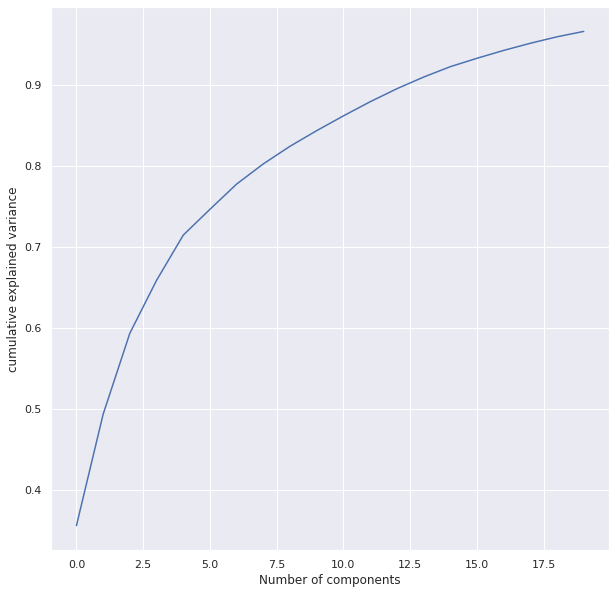

In [743]:
feat_solUD_sc_precursoras = list(columns_by_type['_feat_']) + list(columns_by_type['solUD']) +  list(columns_by_type['chem'])
df_ft_fq_rxn = df[feat_solUD_sc_precursoras]
df_noctes = df_ft_fq_rxn.loc[:, (df_ft_fq_rxn != df_ft_fq_rxn.iloc[0]).any()] 
df_cols = df_noctes.columns
pca_nocte, pca_df_ft_nocte = apply_pca(df, df_cols, 20)
plot_scree_pca(pca_nocte)

In [744]:
pca_nocte.components_[12:,:].shape

(8, 84)

In [745]:
pca_rows = ['PCA_'+ str(n) for n in range(1,9)]


- propiedades FQ = prefijo _feat_
- condiciones de rxn = prefijo _rxn_
- datos usados de sc precursoras = prefijo _raw_

In [747]:
plot_heap_map_with_dendogram(pca_nocte.components_[12:,:], df_cols, pca_rows, 'Prop FQ + condiciones de rxn + datos usados de sc precursoras')